In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import functools
import jax
import jax.numpy as jnp
import jax.scipy.special as jss
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro 
import numpyro.distributions as dist
import numpyro.handlers as nph
from numpyro.infer import NUTS, MCMC
from numpyro.infer.reparam import LocScaleReparam
import pandas as pd
import seaborn as sns

numpyro.enable_x64()
numpyro.set_host_device_count(4)

sns.set_context('notebook')

Jax is always wanting a PRNGKey; this creates a random one.

In [3]:
def jax_prng_key(seed=None):
    if seed is None:
        seed = np.random.randint(1<<32)
    return jax.random.PRNGKey(seed)

Assume we are measuring photometry in some collection of bands; we measure a set of magnitudes for each object,
$$
\vec{A}_\mathrm{obs} = \left( A_0, A_1, \ldots, A_{N-1} \right)^T.
$$
There is an associated "color" space, defined by 
$$
\vec{C}_\mathrm{obs} \equiv \left( A_1 - A_0, A_2 - A_1, \ldots , A_{N-1} - A_{N-2} \right)^T
$$
(note that the "vectors" $\vec{A}$ and $\vec{C}$ have different dimension!).  There are associated "true" magnitudes and colors for each object $\vec{A}$ and $\vec{C}$ (these are "latent"---not directly observed---due to noise in the instrument).  We are looking for an "edge" in the photometry: there is a population of objects with a "brightest" object, such that the population has support only for 
$$
\vec{w} \cdot \vec{A} \geq e
$$
with 
$$
\vec{w} = \left( 1 - c_0, c_0 - c_1, \ldots, c_{N-3}-c_{N-2}, c_{N-2}\right)^T
$$
or, equivalently, 
$$
A_0 + \vec{c} \cdot \vec{C} \geq e.
$$
The vector $\vec{c}$ plays the role of a "color correction" to the limiting magnitude in the 0th photometry band (which is singled out relative to the other bands in the limiting magnitude $e$).  

We imagine that the population with the edge follows a multivariate Gaussian with mean $\vec{\mu}$ and covariance $\mathbf{\Sigma}$ up to the edge:
$$
p\left( \vec{A} \mid \vec{\mu}, \mathbf{\Sigma}, \vec{c}, e \right) \propto \begin{cases}
N\left( \vec{A} \mid \vec{\mu}, \mathbf{\Sigma} \right) & \vec{w} \cdot \vec{A} \geq e \\
0 & \mathrm{otherwise}
\end{cases}
$$

We further imagine there is a second population of contaminants that do not belong to the population with the edge, but nevertheless appear in our photometric catalog.  For these we also assign a multivariate Gaussian population, now with no edge or cut on the photometry
$$
p\left( \vec{A} \mid \vec{\mu}', \mathbf{\Sigma}' \right) \propto N\left( \vec{A} \mid \vec{\mu}', \mathbf{\Sigma}' \right).
$$
The full catalog is a mixture of the two populations, with contamination fraction $\lambda$:
$$
p\left( \vec{A} \mid \vec{\mu}, \vec{\mu}', \mathbf{\Sigma}, \mathbf{\Sigma}', \vec{c}, e, \lambda \right) \propto \left( 1 - \lambda \right) p\left(\vec{A} \mid \vec{\mu}, \mathbf{\Sigma}, \vec{c}, e \right) + \lambda p\left( \vec{A} \mid \vec{\mu}', \mathbf{\Sigma}' \right)
$$

If we assume Gaussian uncertainties on the photometry,
$$
p\left( \vec{A}_\mathrm{obs} \mid \vec{A} \right) \propto N\left( \vec{A}_\mathrm{obs} \mid \vec{A}, \mathbf{\Sigma}_\mathrm{obs} \right),
$$
which (for now, though it is easy to generalize) we will take to have independent noise in each band,
$$
\mathbf{\Sigma}_\mathrm{obs} = \mathrm{diag} \, \left( \vec{\sigma}_\mathrm{obs}^2 \right),
$$
then we can analytically marginalize over the latent true photometric magnitudes, $\vec{A}$.  For the foreground popluation with an edge, we obtain
$$
p\left( \vec{A}_\mathrm{obs} \mid \vec{\mu}, \mathbf{\Sigma}, \vec{c}, e \right) = \int \mathrm{d} \vec{A} \, p\left( \vec{A}_\mathrm{obs} \mid \vec{A} \right) p\left( \vec{A} \mid \vec{\mu}, \mathbf{\Sigma}, \vec{c} \right) = N\left( \vec{A}_\mathrm{obs} \mid \vec{\mu}, \mathbf{\Sigma} + \mathbf{\Sigma}_\mathrm{obs} \right) \alpha
$$
where the normalization $\alpha$ is 
$$
\alpha = \frac{1 + \mathrm{erf}\,\left(\frac{\left( e_\mathrm{obs} - e\right) \sigma_e^2 + \left( \mu_e - e \right) \sigma_{e,\mathrm{obs}}^2}{\sqrt{2} \sigma_e \sigma_{e,\mathrm{obs}} \sqrt{\sigma_e^2 + \sigma_{e,\mathrm{obs}}^2}} \right)}{1 + \mathrm{erf}\left( \frac{\mu_e - e}{\sqrt{2} \sigma_e} \right)},
$$
where
$$
\mu_e = \vec{w} \cdot \vec{\mu},
$$
$$
e_\mathrm{obs} = \vec{w} \cdot \vec{A}_\mathrm{obs},
$$
$$
\sigma_e^2 = \vec{w}^T \mathbf{\Sigma} \vec{w},
$$
and
$$
\sigma_{e,\mathrm{obs}^2} = \vec{w}^T \mathbf{\Sigma}_\mathrm{obs} \vec{w} = \sum_i w_i^2 \sigma_{\mathrm{obs},i}^2
$$
(the last equality holding only for independent photometric uncertainties).

For the background population, we obtain 
$$
p\left( \vec{A}_\mathrm{obs} \mid \vec{\mu}', \mathbf{\Sigma}'\right) = \int \mathrm{d} \vec{A} \, p\left( \vec{A}_\mathrm{obs} \mid \vec{A} \right) p\left( \vec{A} \mid \vec{\mu}', \mathbf{\Sigma}' \right) = N\left( \vec{A}_\mathrm{obs} \mid \vec{\mu}', \mathbf{\Sigma}' + \mathbf{\Sigma}_\mathrm{obs} \right).
$$

Putting the mixture together, the marginal likelihood for an observation $\vec{A}_\mathrm{obs}$ under our population model is 
$$
p\left( \vec{A}_\mathrm{obs} \mid \vec{\mu}, \vec{\mu}', \mathbf{\Sigma}, \mathbf{\Sigma}', \vec{c}, e, \lambda \right) \propto \left( 1 - \lambda \right) N\left( \vec{A}_\mathrm{obs} \mid \vec{\mu}, \mathbf{\Sigma} + \mathbf{\Sigma}_\mathrm{obs} \right) \alpha + \lambda N\left( \vec{A}_\mathrm{obs} \mid \vec{\mu}', \mathbf{\Sigma}' + \mathbf{\Sigma}_\mathrm{obs} \right)
$$

There is one final trick for numerical stability of the gradient.  When evaluating the likelihood function, we are going to have to compute $\alpha$, which will involve computation of 
$$
f(x) = \log\left( 1 + \mathrm{erf}\,\left(x\right) \right).
$$
Some of the photometry will have very small values of $x$, because it is overwhelmingly unlikely to be in the foreground component.  As $x \to -\infty$, $\mathrm{erf}\,\left( x\right) \to -1$, and the above computation becomes subject to a lot of roundoff error.  Additionally, long before $f(x)$ is not representable the gradient computed naively will have a $0/0$ singularity.  To avoid these failures, we switch to a series expansion and custom derivative of the above function whenever $x < 3$ (I checked that the series expansion is sufficiently accurate in this regime):
$$
f(x) = \begin{cases}
\log\left( 1 + \mathrm{erf}\,\left(x\right) \right) & x \geq -3 \\ 
-x^2 - \log\left( - \sqrt{\pi} x \right) - \frac{1}{2 x^2} & x < -3
\end{cases}
$$
whence 
$$
f'(x) = \begin{cases}
\frac{2}{\sqrt{\pi}} \frac{e^{-x^2}}{1 + \mathrm{erf}\,\left( x \right)} & x \geq -3 \\ 
-2 x - \frac{1}{x} + \frac{1}{x^3} & x < -3
\end{cases}
$$

In [20]:
from jax import custom_jvp

@custom_jvp
def log1p_erf(x):
    x = jnp.array(x)
    return jnp.where(x < -3.0, -x*x - jnp.log(-jnp.sqrt(np.pi)*x) - 0.5/(x*x), jnp.log1p(jss.erf(x)))

@log1p_erf.defjvp
def log1p_erf_jvp(primals, tangents):
    x, = primals
    dx, = tangents

    ans = jnp.where(x < -3.0, -x*x - jnp.log(-jnp.sqrt(np.pi)*x) - 0.5/(x*x), jnp.log1p(jss.erf(x)))
    ans_dot = jnp.where(x < -3.0, -2*x - 1/x + 1/(x*x*x), 2/jnp.sqrt(np.pi)*jnp.exp(-x*x)/(1 + jss.erf(x)))
    return ans, ans_dot*dx

def log_edge_normalization_factor(e, mu_e, sigma_e, e_obs, sigma_e_obs):
    sigma_e2 = sigma_e*sigma_e
    sigma_e_obs2 = sigma_e_obs*sigma_e_obs
    
    obs_arg = ((e_obs - e)*sigma_e2 + (mu_e - e)*sigma_e_obs2)/(jnp.sqrt(2)*sigma_e*sigma_e_obs*jnp.sqrt(sigma_e2 + sigma_e_obs2))
    pop_arg = (mu_e-e)/(jnp.sqrt(2)*sigma_e)

    log_numer = log1p_erf(obs_arg)
    log_denom = log1p_erf(pop_arg)

    return log_numer - log_denom

def edge_model(Aobs, sigma_obs, f_bg_prior=0.1, f_bg_confidence=10, e_mu=0.0, e_sigma=1.0, mu_bg=None, cov_bg=None, f_bg=None):
    Aobs = np.array(Aobs)
    sigma_obs = np.array(sigma_obs)

    nobs, nband = Aobs.shape
    assert sigma_obs.shape == (nobs, nband), 'size mismatch between `Aobs` and `sigma_obs`'

    cov_obs = np.zeros((nobs, nband, nband))
    j,k = np.diag_indices(nband)
    cov_obs[:,j,k] = np.square(sigma_obs)

    if f_bg is None:
        f_bg = numpyro.sample('f_bg', dist.Uniform())

    c = numpyro.sample('c', dist.Normal(loc=0, scale=1), sample_shape=(nband-1,))
    w = numpyro.deterministic('w', jnp.concatenate((jnp.array([1-c[0]]), -jnp.diff(c), jnp.array([c[-1]]))))

    e_rescaled = numpyro.sample('e_rescaled', dist.Normal(loc=0, scale=1))
    e = numpyro.deterministic('e', e_mu + e_sigma*e_rescaled)

    mu_fg = numpyro.sample('mu_fg', dist.Normal(loc=0, scale=1), sample_shape=(nband,))
    scale_fg = numpyro.sample('scale_fg', dist.HalfNormal(scale=1), sample_shape=(nband,))
    corr_fg_cholesky = numpyro.sample('corr_fg_cholesky', dist.LKJCholesky(nband, 3))
    cov_fg_cholesky = numpyro.deterministic('cov_fg_cholesky', scale_fg[:,None]*corr_fg_cholesky)
    cov_fg = numpyro.deterministic('cov_fg', jnp.matmul(cov_fg_cholesky, cov_fg_cholesky.T))

    if mu_bg is None and cov_bg is None:
        mu_bg = numpyro.sample('mu_bg', dist.Normal(loc=0, scale=1), sample_shape=(nband,))
        scale_bg = numpyro.sample('scale_bg', dist.HalfNormal(scale=1), sample_shape=(nband,))
        corr_bg_cholesky = numpyro.sample('corr_bg_cholesky', dist.LKJCholesky(nband, 3))
        cov_bg_cholesky = numpyro.deterministic('cov_bg_cholesky', scale_bg[:,None]*corr_bg_cholesky)
        cov_bg = numpyro.deterministic('cov_bg', jnp.matmul(cov_bg_cholesky, cov_bg_cholesky.T))

    mu_e = jnp.dot(w, mu_fg)
    e_obs = jnp.dot(Aobs, w)
    sigma_e2 = jnp.dot(w, jnp.dot(cov_fg, w))
    sigma_e = jnp.sqrt(sigma_e2)
    sigma_e_obs2 = jnp.sum(w[None,:]*w[None,:]*sigma_obs*sigma_obs, axis=1)
    sigma_e_obs = jnp.sqrt(sigma_e_obs2)

    log_alpha = numpyro.deterministic('log_alpha', log_edge_normalization_factor(e, mu_e, sigma_e, e_obs, sigma_e_obs))

    logp_fg = numpyro.deterministic('logp_fg', jnp.log1p(-f_bg) + dist.MultivariateNormal(loc=mu_fg[None,:], covariance_matrix=cov_fg[None,:,:]+cov_obs).log_prob(Aobs) + log_alpha)
    logp_bg = numpyro.deterministic('logp_bg', jnp.log(f_bg) + dist.MultivariateNormal(loc=mu_bg[None,:], covariance_matrix=cov_bg[None,:,:]+cov_obs).log_prob(Aobs))

    numpyro.factor("likelihood", jnp.sum(jnp.logaddexp(logp_fg, logp_bg)))

Now let's make some mock data.  We draw $A_0 \sim N(0,1)$, and $A_1 = A_0 + 0.5 + 0.2 * N(0,1)$, and $A_2 = A_0 - 0.2 + 0.5*N(0,1)$, subject to the edge constraint.  Thus 
$$
\Sigma = \begin{pmatrix}
1 & 1 & 1 \\
1 & 1.04 & 1 \\
1 & 1 & 1.25
\end{pmatrix}
$$

For the background, we use the same mean relations, but double the scatter, so that the covariance becomes 
$$
\Sigma = \begin{pmatrix}
4 & 4 & 4 \\
4 & 4.16 & 4 \\
4 & 4 & 5
\end{pmatrix}
$$

In [21]:
Nfg = 1000
Nbg = 100
N = Nfg+Nbg
Nband = 3
edge = -0.5

e_mu = edge
e_sigma = 0.1

c = np.array([0.1, -0.1])
w = np.array([1-c[0], c[0]-c[1], c[1]])

sigma_obs = np.array([0.1, 0.1, 0.1])[None,:]*np.ones((N, Nband))
mu_fg = np.array([0.0, 0.5, -0.2])
mu_bg = np.zeros(3)

cov_fg = np.array([[1.0, 1.0, 1.0], [1.0, 1.04, 1.0], [1.0, 1.0, 1.25]])
scale_fg = np.sqrt(np.diag(cov_fg))
cov_bg = np.array([[4.0, 4.0, 4.0], [4.0, 8.0, 8.0], [4.0, 8.0, 12.0]])
scale_bg = np.sqrt(np.diag(cov_bg))

corr_fg = cov_fg / (scale_fg[:,None]*scale_fg[None,:])
corr_bg = cov_bg / (scale_bg[:,None]*scale_bg[None,:])

chol_corr_fg = np.linalg.cholesky(corr_fg)
chol_corr_bg = np.linalg.cholesky(corr_bg)

init_params = {
    'f_bg': Nbg/N,
    'e': edge,
    'c': c,
    'mu_fg': mu_fg,
    'scale_fg': scale_fg,
    'corr_fg_cholesky': jnp.array(chol_corr_fg)
}

Aobs = []
nf = 0
while nf < Nfg:
    A = np.random.multivariate_normal(mu_fg, cov_fg)
    e = np.dot(w, A)
    if e < edge:
        pass
    else:
        Ao = A + sigma_obs[nf,:]*np.random.randn(Nband)
        Aobs.append(Ao)
        nf += 1

for i in range(Nbg):
     Aobs.append(np.random.multivariate_normal(mu_bg, cov_bg + np.diag(sigma_obs[Nfg+i,:]*sigma_obs[Nfg+i,:])))
Aobs = np.array(Aobs)
    

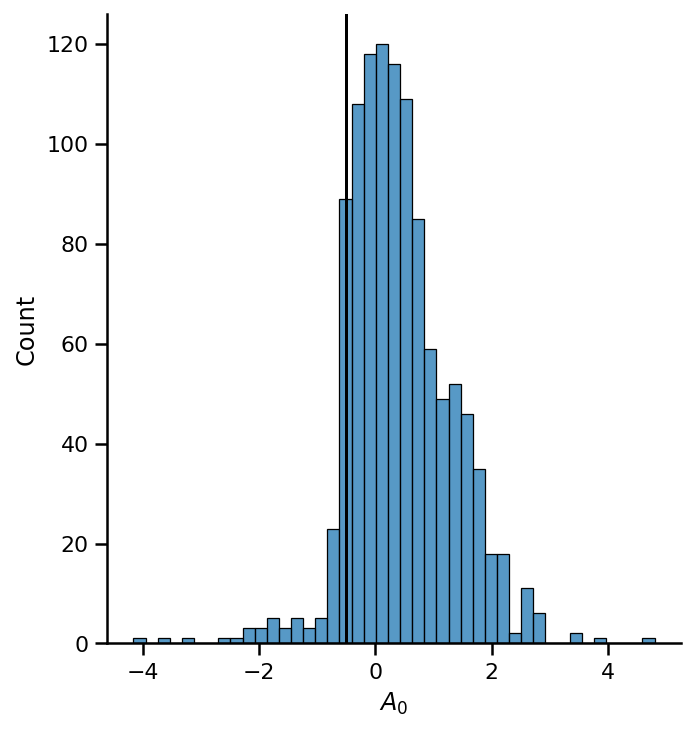

In [22]:
sns.displot(Aobs[:,0])
plt.xlabel(r'$A_0$')
plt.axvline(edge, color='k')

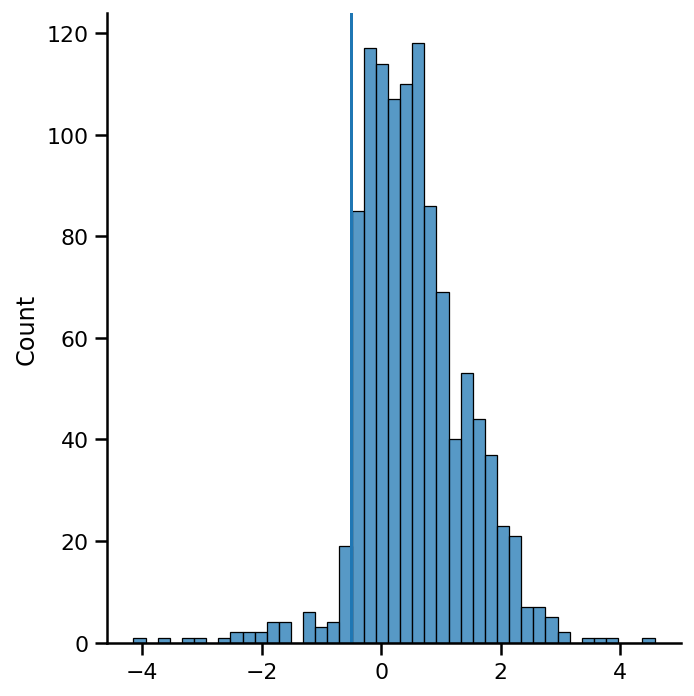

In [23]:
eobs = np.dot(Aobs, w)
sigma_eobs = np.sqrt(np.sum(w[None,:]*w[None,:]*sigma_obs*sigma_obs, axis=1))
mu_e = np.dot(w, mu_fg)
sigma_e = np.sqrt(np.dot(w, np.dot(cov_fg, w)))

sns.displot(eobs)
plt.axvline(edge)

In [24]:
log_alpha_true = log_edge_normalization_factor(edge, mu_e, sigma_e, eobs, sigma_eobs)

Text(0, 0.5, '$A_0$')

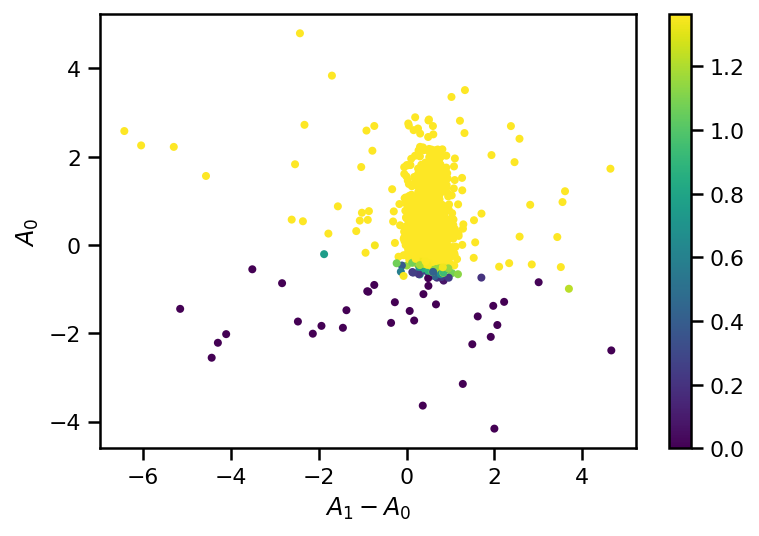

In [25]:
plt.scatter(Aobs[:Nfg,1]-Aobs[:Nfg,0], Aobs[:Nfg,0], marker='.', c=np.exp(log_alpha_true)[:Nfg])
plt.scatter(Aobs[Nfg:,1]-Aobs[Nfg:,0], Aobs[Nfg:,0], marker='.', c=np.exp(log_alpha_true)[Nfg:])
plt.colorbar()
plt.xlabel(r'$A_1 - A_0$')
plt.ylabel(r'$A_0$')

Text(0, 0.5, '$A_1$')

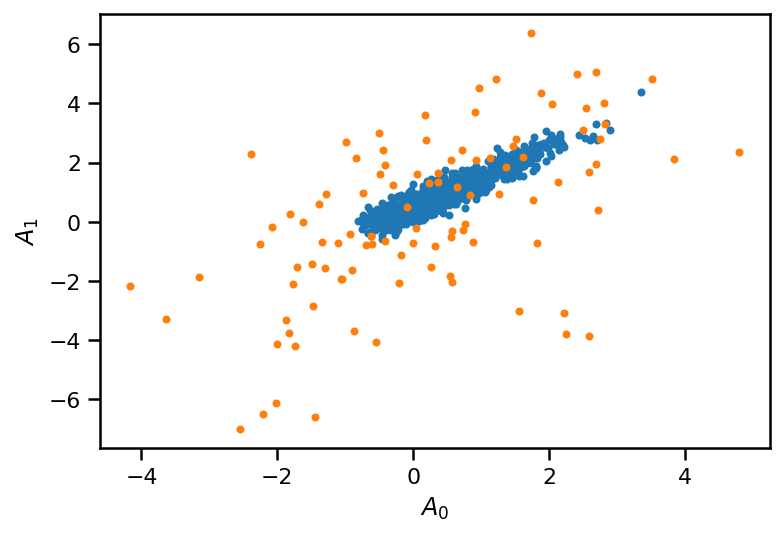

In [26]:
plt.scatter(Aobs[:Nfg,0], Aobs[:Nfg,1], marker='.')
plt.scatter(Aobs[Nfg:,0], Aobs[Nfg:,1], marker='.')
plt.xlabel(r'$A_0$')
plt.ylabel(r'$A_1$')

In [34]:
sampler = NUTS(edge_model, dense_mass=True)
mcmc = MCMC(sampler, num_warmup=2000, num_samples=1000, num_chains=4)
mcmc.run(jax_prng_key(), Aobs, sigma_obs, e_mu=e_mu, e_sigma=e_sigma)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [36]:
trace = az.from_numpyro(mcmc)
az.summary(trace, var_names=['e', 'c','mu_fg', 'cov_fg', 'mu_bg', 'cov_bg'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
e,-0.513,0.036,-0.580,-0.447,0.000,0.000,6853.0,3033.0,1.0
c[0],0.115,0.072,-0.016,0.256,0.001,0.001,7295.0,3204.0,1.0
c[1],-0.083,0.039,-0.160,-0.013,0.000,0.000,7554.0,3113.0,1.0
mu_fg[0],0.009,0.091,-0.158,0.173,0.001,0.002,5952.0,2876.0,1.0
mu_fg[1],0.526,0.091,0.361,0.693,0.001,0.001,5957.0,2943.0,1.0
mu_fg[2],-0.165,0.086,-0.333,-0.021,0.001,0.001,5861.0,2804.0,1.0
"cov_fg[0, 0]",0.986,0.102,0.802,1.172,0.001,0.001,5454.0,2917.0,1.0
"cov_fg[0, 1]",0.980,0.102,0.795,1.166,0.001,0.001,5536.0,2672.0,1.0
"cov_fg[0, 2]",0.944,0.098,0.768,1.127,0.001,0.001,5538.0,2893.0,1.0
"cov_fg[1, 0]",0.980,0.102,0.795,1.166,0.001,0.001,5536.0,2672.0,1.0


In [37]:
logp_fg = trace.posterior.logp_fg.values - np.logaddexp(trace.posterior.logp_fg.values, trace.posterior.logp_bg.values)

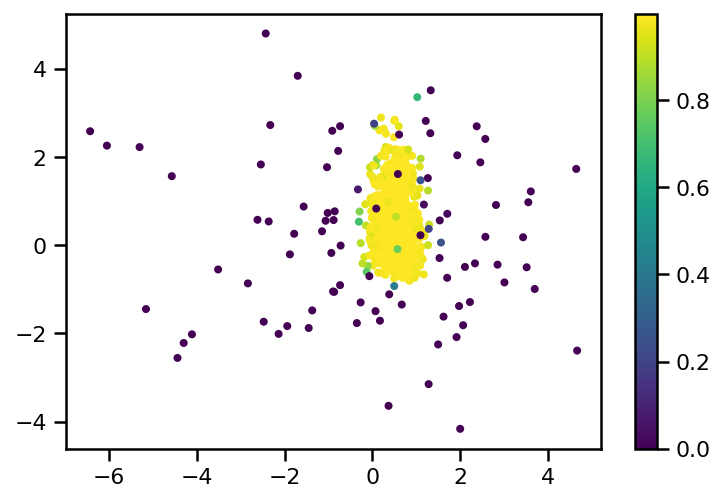

In [38]:
plt.scatter(Aobs[:,1]-Aobs[:,0], Aobs[:,0], c=np.mean(np.exp(logp_fg), axis=(0,1)), marker='.')
plt.colorbar()

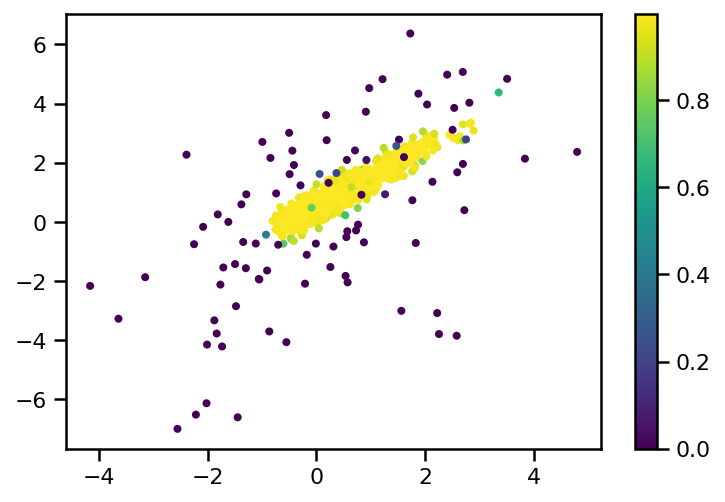

In [39]:
plt.scatter(Aobs[:,0], Aobs[:,1], c=np.mean(np.exp(logp_fg), axis=(0,1)), marker='.')
plt.colorbar()

array([[<AxesSubplot:title={'center':'e'}>,
        <AxesSubplot:title={'center':'e'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'mu_bg'}>,
        <AxesSubplot:title={'center':'mu_bg'}>],
       [<AxesSubplot:title={'center':'scale_bg'}>,
        <AxesSubplot:title={'center':'scale_bg'}>]], dtype=object)

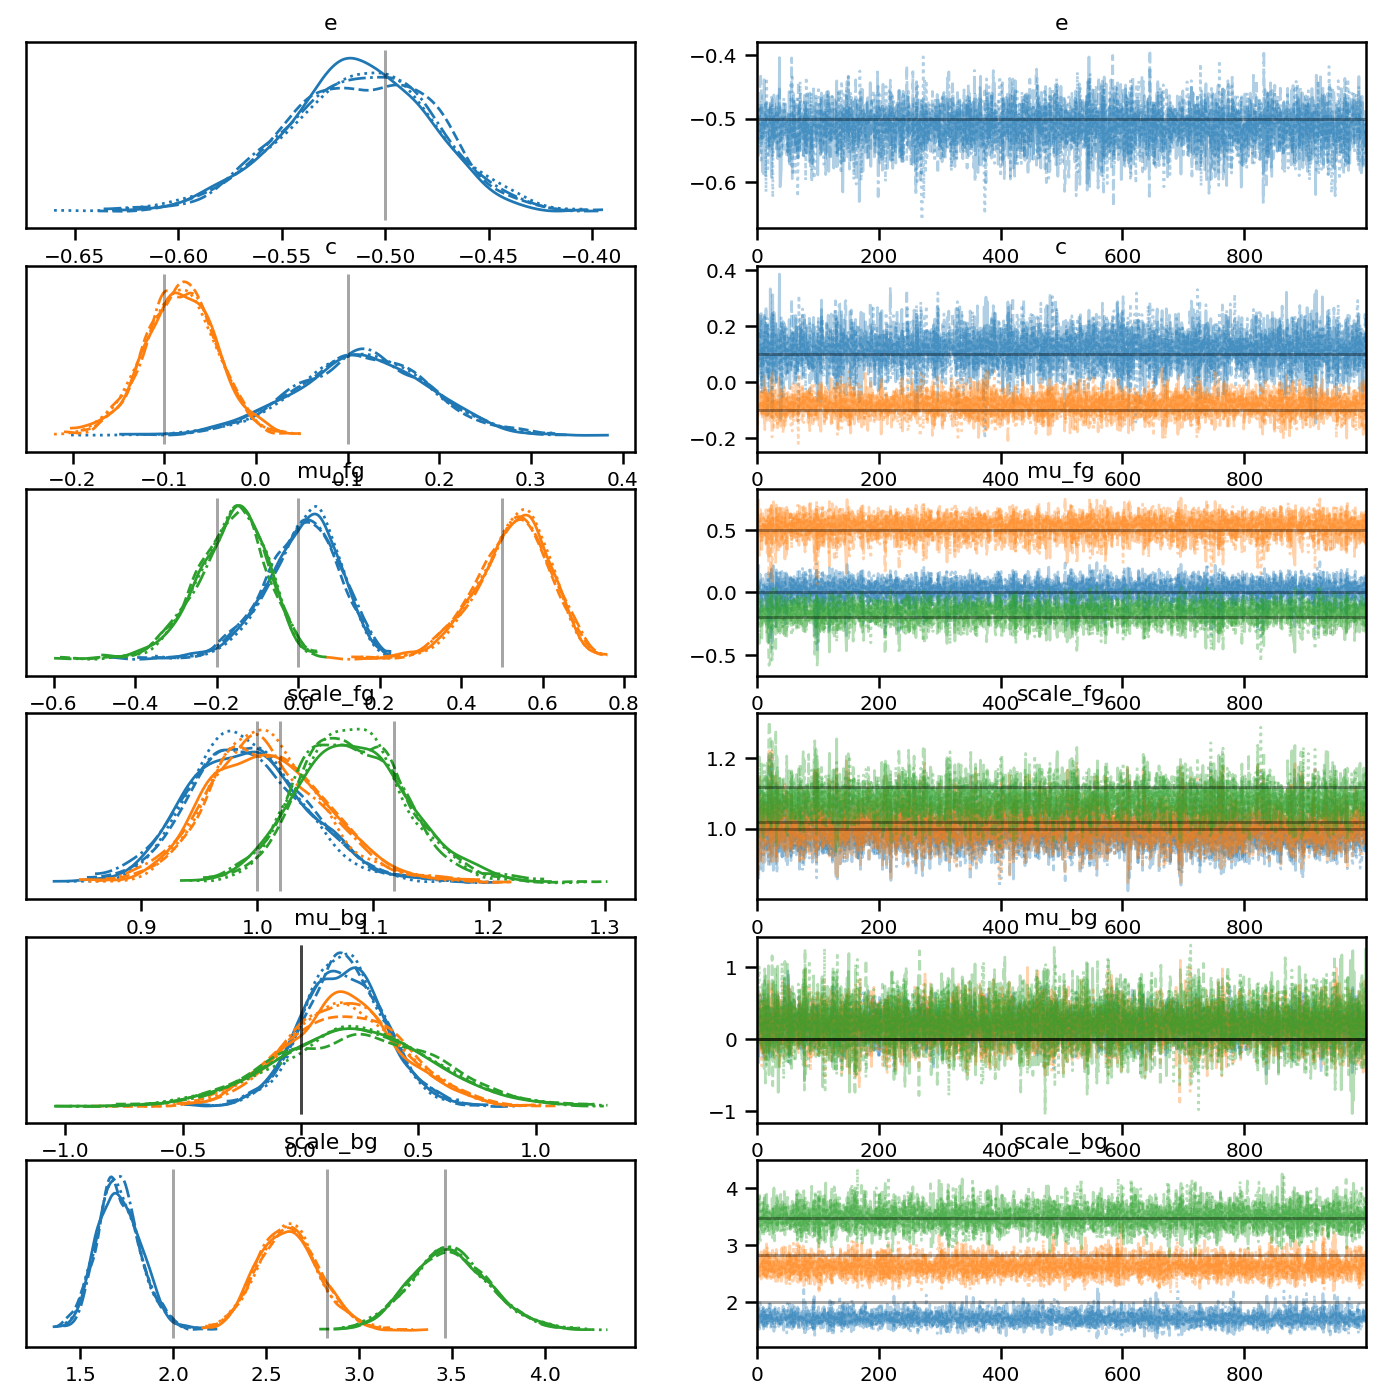

In [41]:
az.plot_trace(trace, var_names=['e', 'c', 'mu_fg', 'scale_fg', 'mu_bg', 'scale_bg'],
              lines=[('mu_fg', {}, mu_fg), ('e', {}, edge), ('c', {}, c), ('scale_fg', {}, scale_fg), ('mu_bg', {}, mu_bg), ('scale_bg', {}, scale_bg)])